# Figure 3

In [1]:
%load_ext autoreload
%autoreload 2

In [50]:
import numpy as np
import matplotlib as mpl
import matplotlib.pylab as plt
import time
import importlib
from copy import deepcopy

import sys
sys.path.append("../model/")
sys.path.append('../../')

from common import col, svg, samples_nd, get_labels_8pt
from pyloric import simulate, create_prior, get_time, simulate_energyscape
import viz
from helper_functions import get_gradient, active_subspace

from sbi.utils.regression_net.get_nn_classifier import classifier
from sbi.utils.regression_net.train_classifier import fit_regression_net

In [3]:
PANEL_A = '../svg/panel_a.svg'
PANEL_B = '../svg/panel_b.svg'
PANEL_C = '../svg/panel_c.svg'

### Load experimental data

In [4]:
prior_11 = create_prior(log=True)
dimensions_11 = 31
lims_11 = np.asarray([-np.sqrt(3)*np.ones(dimensions_11), np.sqrt(3)*np.ones(dimensions_11)]).T

params_mean_11 = prior_11.mean.numpy()
params_std_11 = prior_11.stddev.numpy()

In [5]:
data = np.load('../../results/11deg_post_pred/11_deg_post_pred_close_to_obs.npz')
good_stats = data['sample_stats']
good_params = data['sample_params']
good_seeds = data['sample_seeds']

In [6]:
sample_params = good_params
sample_stats = good_stats
print('There are', len(good_seeds), 'datapoints in this dataset')

There are 55043 datapoints in this dataset


In [7]:
sample_stats = data['sample_stats']
sample_params = data['sample_params']
sample_seeds = data['sample_seeds']

In [8]:
energies = sample_stats[:, 21:24]
summed_energies = np.sum(energies, axis=1)

### Quantify the variances

In [9]:
prior_11.support.lower_bound

tensor([ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         1.5700e-02,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         1.2560e-03,  6.2800e-03,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         6.2800e-06,  0.0000e+00,  0.0000e+00,  0.0000e+00,  1.8840e-02,
         0.0000e+00,  3.1400e-02,  0.0000e+00,  0.0000e+00, -1.8421e+01,
        -1.8421e+01, -1.8421e+01, -1.8421e+01, -1.8421e+01, -1.8421e+01,
        -1.8421e+01], dtype=torch.float64)

In [10]:
prior_range = (prior_11.support.upper_bound - prior_11.support.lower_bound).numpy()

In [11]:
inds = np.argsort(summed_energies)
sorted_energies = np.sort(summed_energies)
sorted_params = sample_params[inds]
sorted_ss = sample_stats[inds]

In [12]:
all_means = []
for quantile in [0.99, 0.75, 0.5, 0.25, 0.01]:

    sample_stats = data['sample_stats']
    sample_params = data['sample_params']
    sample_seeds = data['sample_seeds']

    num_samples = 1000
    num_vals = len(summed_energies)
    params_to_plot = sorted_params[int(num_vals*quantile - num_samples/2):int(num_vals*quantile + num_samples/2)]
    energy_thr = sorted_energies[int(num_vals*quantile)]
    
    mean_of_these_params = np.mean(params_to_plot, axis=0)
    all_means.append(mean_of_these_params)
all_means = np.asarray(all_means)

In [13]:
energy_thr

1721441.8802888643

### Plot histogram

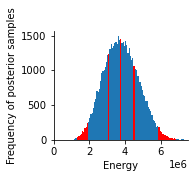

In [14]:
fig, ax = plt.subplots(1,1, figsize=(2.4,2))
    
N, bins, patches = ax.hist(summed_energies, bins=100)
    
for quantile in [0.99, 0.75, 0.5, 0.25, 0.01]:
    sample_stats = data['sample_stats']
    sample_params = data['sample_params']
    sample_seeds = data['sample_seeds']

    num_samples = 1000
    num_vals = len(summed_energies)
    params_to_plot = sorted_params[int(num_vals*quantile - num_samples/2):int(num_vals*quantile + num_samples/2)]
    energy_thr_low = sorted_energies[int(num_vals*quantile - num_samples/2)]
    energy_thr_high = sorted_energies[int(num_vals*quantile + num_samples/2)]
        
    for i, b in enumerate(bins):
        if b > energy_thr_low and b < energy_thr_high:
            patches[i].set_facecolor('r')
    
ax.set_xlim(0, 7500000)
ax.set_xlabel("Energy")
ax.set_ylabel("Frequency of posterior samples")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

#plt.savefig('../results/energy/figs_new/histogram.png', dpi=300, bbox_inches='tight')

In [15]:
shift_in_mean = all_means[0] - all_means[-1]
shift_in_mean_normalized = shift_in_mean/prior_range

In [16]:
sort_inds = np.argsort(np.abs(shift_in_mean_normalized))
strongest_variation_inds = np.sort(sort_inds[-8:]) # these are used for plots

In [17]:
labels_ = get_labels_8pt()
labels_[9] += ''

In [18]:
from decimal import Decimal
all_labels = []
lims=lims_11
params_std = params_std_11
params_mean = params_mean_11
for dim_i in range(31):
    if dim_i > len(params_mean_11) - 7.5: # synapses
        if dim_i == 24: all_labels.append([r'$\mathdefault{0.01}$     ', r'$\mathdefault{10000}\;\;\;\;$   '])
        else: all_labels.append([r'$\mathdefault{0.01}$ ', r'$\mathdefault{1000}\;\;\;\;$ '])
    else: # membrane conductances
        num_after_digits = -int(np.log10(lims[dim_i, 1] * params_std[dim_i] + params_mean[dim_i]))
        if num_after_digits > 2:
            num_after_digits=2
        labels = [round(Decimal((lims[dim_i, num_tmp] * params_std[dim_i] + params_mean[dim_i]) / 0.628e-3), num_after_digits)
                  for num_tmp in range(2)]
        new_labels = []
        counter=0
        for l in labels:
            if counter == 0:
                new_labels.append(r'$\mathdefault{'+str(l)+'}$  ')
            else:
                new_labels.append(r'$\mathdefault{'+str(l)+'}\;\;\;$  ')
            counter+=1
        all_labels.append(new_labels)

# Panel 0: Fit regression net

In [248]:
energies = torch.as_tensor(energies)

In [249]:
num_test = 500

test_params = good_params[:num_test]
train_params = good_params[num_test:]
mean_params = np.mean(train_params, axis=0)
std_params = np.std(train_params, axis=0)

train_params_norm = (train_params - mean_params) / std_params
test_params_norm = (test_params - mean_params) / std_params

In [250]:
train_energy_ABPD = torch.sum(energies[num_test:], dim=1).unsqueeze(1)
test_energy_ABPD = torch.sum(energies[:num_test], dim=1).unsqueeze(1)
mean_energy = torch.mean(train_energy_ABPD)
std_energy = torch.std(train_energy_ABPD)
train_energy_ABPD_norm = (train_energy_ABPD - mean_energy) / std_energy
test_energy_ABPD_norm = (test_energy_ABPD - mean_energy) / std_energy

In [251]:
nn = classifier(dim=31)

In [252]:
converged_nn = fit_regression_net(
    nn,
    train_params_norm,
    train_energy_ABPD_norm,
    num_train=train_params_norm.shape[0],
    batch_size=50,
    stop_after_epochs=10,
    max_epochs=10
)

Total number of trainable parameters 169001
Training loss   0.002328025762005703
validation loss 0.0007068722019711293
Training loss   0.000846119177882284
validation loss 0.0005732241772135718
Training loss   0.0006648643477182384
validation loss 0.0004943799570639891
Training loss   0.0005741616643819839
validation loss 0.00040918740040113026
Training loss   0.0005173680588139787
validation loss 0.0003653149041120991
Training loss   0.00047767753449494486
validation loss 0.00036048427408545745
Training loss   0.00045224866688884724
validation loss 0.00031827951036222913
Training loss   0.0004240153251519983
validation loss 0.0003032103305516934
Training loss   0.00041278452559564304
validation loss 0.00030878438050051986
Training loss   0.0003952532907821313
validation loss 0.0003024494330083745
Training loss   0.00038366648250907865
validation loss 0.00029515441554904965


In [256]:
import torch
predictions = converged_nn.predict(torch.as_tensor(test_params_norm)).detach()

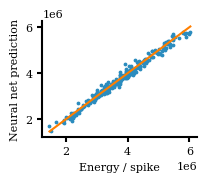

In [257]:
with mpl.rc_context(fname='../../.matplotlibrc'):
    fig, ax = plt.subplots(1,1, figsize=(2,1.5))
    unnorm_x = test_energy_ABPD_norm[:300] * std_energy + mean_energy
    unnorm_y = predictions[:300] * std_energy + mean_energy
    ax.scatter(x=unnorm_x.numpy(), y=unnorm_y.numpy(), s=3, color='#2b8cbe')
    gt_vec = np.linspace(np.min(unnorm_x.numpy()), np.max(unnorm_x.numpy()), 2)
    ax.plot(gt_vec, gt_vec, '#ff7f00')
    ax.set_xlabel('Energy / spike')
    ax.set_ylabel('Neural net prediction')

In [258]:
cum_grad = get_gradient(converged_nn, test_params_norm)

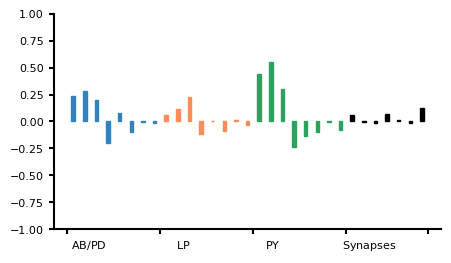

In [259]:
with mpl.rc_context(fname='../../.matplotlibrc'):
    viz.all_sensitivity_bars(cum_grad, ylim=[-1,1], figsize=(5.0, 2.8))
    plt.show()

In [260]:
e_vals, e_vecs = active_subspace(converged_nn, test_params_norm)

### Plot all 31D eigenvalues
It seems that energy lies largely in a 1D subspace. As we will show below, within theis subspace, it is possible to optimize both the energy/spike and the number of spikes.

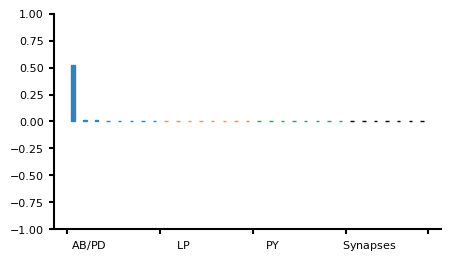

In [261]:
with mpl.rc_context(fname='../../.matplotlibrc'):
    viz.all_sensitivity_bars(e_vals[:,:1].T, ylim=[-1,1], figsize=(5.0, 2.8))
    plt.show()

### Plot first eigenvector

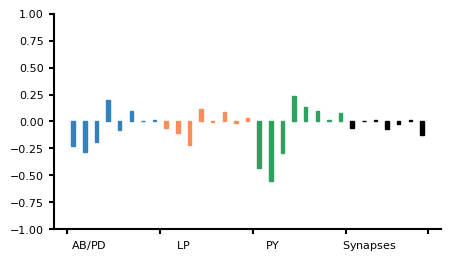

In [262]:
with mpl.rc_context(fname='../../.matplotlibrc'):
    viz.all_sensitivity_bars(e_vecs[:, :1].T, ylim=[-1,1], figsize=(5.0, 2.8))
    plt.show()

### Project into 1D plane

In [263]:
num_scatter = 1000

projection_mat = e_vecs[:, :1]
train_params_norm_tt = torch.as_tensor(train_params_norm)[:num_scatter]
all_train_params_norm_tt = torch.as_tensor(train_params_norm)
projected = torch.mm(train_params_norm_tt, projection_mat)[:num_scatter]
all_projected = torch.mm(all_train_params_norm_tt, projection_mat)

In [264]:
veryleast_value = torch.argmin(projected[:,0])
projected = torch.cat((projected[:veryleast_value], projected[veryleast_value+1:]))
train_params_norm_tt = torch.cat((train_params_norm_tt[:veryleast_value,:], train_params_norm_tt[veryleast_value+1:,:]), axis = 0)
print('projected', projected.shape)
print('train_params_norm_tt', train_params_norm_tt.shape)
minimal_dim0_set = projected[torch.argmin(projected[:,0])]
maximal_dim0_set = projected[torch.argmax(projected[:,0])]

projected torch.Size([999, 1])
train_params_norm_tt torch.Size([999, 31])


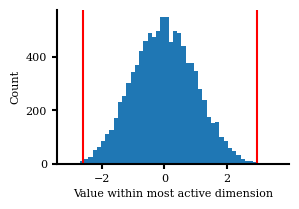

In [265]:
with mpl.rc_context(fname='../../.matplotlibrc'):
    fig, ax = plt.subplots(1,1, figsize=(3,2))
    _ = ax.hist(all_projected[:10000].T, bins=50)
    ax.axvline(minimal_dim0_set, c='r')
    ax.axvline(maximal_dim0_set, c='r')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xlabel('Value within most active dimension')
    ax.set_ylabel('Count')

### Simulate the most extreme cases

In [266]:
unnorm_set_dim0_min = train_params_norm_tt[torch.argmin(projected[:,0])] * std_params + mean_params
unnorm_set_dim0_max = train_params_norm_tt[torch.argmax(projected[:,0])] * std_params + mean_params
simulation_output_dim0_min = simulate_energyscape(unnorm_set_dim0_min, seed=0)
simulation_output_dim0_max = simulate_energyscape(unnorm_set_dim0_max, seed=0)

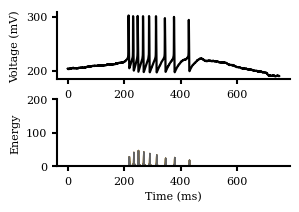

In [231]:
with mpl.rc_context(fname='../../.matplotlibrc'):
    viz.energy_scape(
        simulation_output_dim0_min,
        get_time(),
        (3,2),
        ['k', 'k', 'k'],
        time_len=30000,
        offset = 55000,
    )

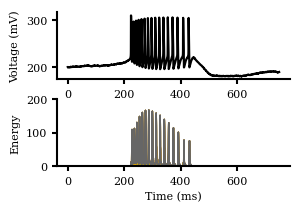

In [232]:
with mpl.rc_context(fname='../../.matplotlibrc'):
    viz.energy_scape(
        simulation_output_dim0_max,
        get_time(),
        (3,2),
        ['k', 'k', 'k'],
        time_len=30000,
        offset = 15000,
    )

# Panel A: posterior for parameters that change a lot

../model/viz.py:143: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if opts['labels'] == [] or opts['labels'] is None:
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


energy_thr 5845257.641395471 6811771.800065166
energy_thr 1283508.8495112432 1894319.0407199033


findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


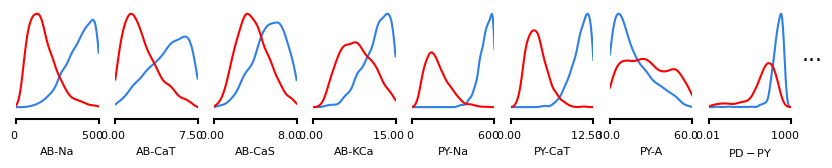

In [21]:
all_sample_params = []

for i, quantile in enumerate([0.99, 0.01]):
    sample_stats = data['sample_stats']
    sample_params = data['sample_params']
    sample_seeds = data['sample_seeds']

    num_samples = 1000
    num_vals = len(summed_energies)
    params_to_plot = sorted_params[int(num_vals*quantile - num_samples/2):int(num_vals*quantile + num_samples/2)]
    energy_thr_low = sorted_energies[int(num_vals*quantile - num_samples/2)]
    energy_thr_high = sorted_energies[int(num_vals*quantile + num_samples/2)]
    print("energy_thr", energy_thr_low, energy_thr_high)

    sample_params = (params_to_plot - params_mean_11) / params_std_11
    all_sample_params.append(sample_params)

with mpl.rc_context(fname='../../.matplotlibrc'):
    fig, axes = viz.oneDmarginal(samples=all_sample_params,
                           subset=strongest_variation_inds.tolist(),
                           limits=lims,
                           ticks=lims,
                           tick_labels=all_labels,
                           fig_size=(10, 1.3),
                           labels=labels_,
                           samples_colors=[col['SNPE'], 'r'],
                           diag=['kde', 'kde'],
                           hist_offdiag={'bins':50})
    #plt.savefig(PANEL_A, facecolor='None', transparent=True)
    plt.show()

# Panel B: posterior for parameters that barely change

In [22]:
sort_inds = np.argsort(np.abs(shift_in_mean_normalized))
weakest_variation_inds = np.sort(sort_inds[:8]) # these are used for plots

../model/viz.py:143: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if opts['labels'] == [] or opts['labels'] is None:


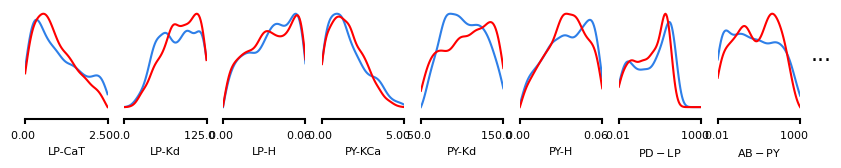

In [27]:
all_sample_params = []

for i, quantile in enumerate([0.99, 0.01]):
    sample_stats = data['sample_stats']
    sample_params = data['sample_params']
    sample_seeds = data['sample_seeds']

    num_samples = 1000
    num_vals = len(summed_energies)
    params_to_plot = sorted_params[int(num_vals*quantile - num_samples/2):int(num_vals*quantile + num_samples/2)]

    sample_params = (params_to_plot - params_mean_11) / params_std_11
    all_sample_params.append(sample_params)

with mpl.rc_context(fname='../../.matplotlibrc'):
    fig, axes = viz.oneDmarginal(samples=all_sample_params,
                           subset=weakest_variation_inds.tolist(),
                           limits=lims,
                           ticks=lims,
                           tick_labels=all_labels,
                           fig_size=(10, 1.3),
                           labels=labels_,
                           samples_colors=[col['SNPE'], 'r'],
                           diag=['kde', 'kde'],
                           hist_offdiag={'bins':50})
    #plt.savefig(PANEL_B, facecolor='None', transparent=True)
    plt.show()

# Panel C: summarize

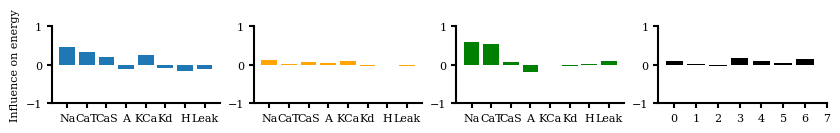

In [24]:
with mpl.rc_context(fname='../../.matplotlibrc'):
    viz.sensitivity_hist(shift_in_mean_normalized, figsize=(10,1))
    #plt.savefig(PANEL_C, facecolor='None', transparent=True)

# Assemble figure

In [25]:
import time
import IPython.display as IPd

def svg(img):
    IPd.display(IPd.HTML('<img src="{}" / >'.format(img, time.time())))

In [26]:
from svgutils.compose import *

# > Inkscape pixel is 1/90 of an inch, other software usually uses 1/72.
# > http://www.inkscapeforum.com/viewtopic.php?f=6&t=5964
svg_scale = 1.25  # set this to 1.25 for Inkscape, 1.0 otherwise
factor_svg=5.5

# Panel letters in Helvetica Neue, 12pt, Medium
kwargs_text = {'size': '12pt', 'font': 'Arial', 'weight': '800'}
kwargs_consistent = {'size': '10pt', 'font': 'Arial', 'weight': '500', 'color': '#AF99EF'}
kwargs_consistent1 = {'size': '10pt', 'font': 'Arial', 'weight': '500', 'color': '#9E7DD5'}
kwargs_inconsistent = {'size': '10pt', 'font': 'Arial', 'weight': '500', 'color': '#AF99EF'}
kwargs_text8pt = {'size': '7.7pt', 'font': 'Arial'}

f = Figure("20.3cm", "11.0cm",

    Panel(
          SVG(PANEL_A).scale(svg_scale).move(0, 0*factor_svg),
          Text("a", 0.0*factor_svg, 2.5*factor_svg, **kwargs_text),
    ).move(0*factor_svg, 0*factor_svg),
    
    Panel(
        SVG(PANEL_B).scale(svg_scale).move(0*factor_svg, 0*factor_svg),
        Text("b", 0.0*factor_svg, 2.5*factor_svg, **kwargs_text),
    ).move(0*factor_svg, 28*factor_svg),
    
    Panel(
          SVG(PANEL_C).scale(svg_scale).move(0*factor_svg,0*factor_svg),
          Text("c", 0.0*factor_svg, 2.0*factor_svg, **kwargs_text),
    ).move(0*factor_svg, 56*factor_svg),
)

!mkdir -p fig
f.save("../fig/fig3.svg")
svg('../fig/fig3.svg')